<a href="https://colab.research.google.com/github/annajli/gaussian_processes/blob/main/Hyperparameter_Tuning_Techniques_for_Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hyperparameter Tuning Techniques for Gaussian Processes**

### Harvard DtAK Lab
#### Papers: 
* GP for Regression (Rathmusen & Williams) https://proceedings.neurips.cc/paper/1995/file/7cce53cf90577442771720a370c3c723-Paper.pdf
* (Ebden) https://arxiv.org/pdf/1505.02965.pdf

#### Author: Anna Li

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from pymc3 import model_to_graphviz, Model
import pymc3 as pm
from autograd import grad
from autograd import numpy as np
from autograd.misc.optimizers import adam, sgd
import seaborn as sns

In [ ]:
# pairwise collection of points, we construct a kernel matrix K 
# using input kernel function kernel_fn
# the resulting matrix should be of dimension len(x) by len(Y)
def construct_kernel(X, Y, kernel_fn):
  final = np.array([[kernel_fn(X[i,:], Y[j, :]) for j in range(Y.shape[0])] for i in range(X.shape[0])])
  final = final[:,:,0]
  # add a bit of noise to prevent matrix singularity but doesn't work well with autograd
  # np.fill_diagonal(final, final.diagonal() + 10**(-6))
  return final

In [ ]:
# Computes Mean and Variance of Conditional Distribution f* | X, X*, f
def compute_mean_and_covariance(kernel, x, x_star, f, sigma_n=0):
  # use the mean and covariance dervied for the GP process for regression
  jointKernel_1 = kernel(x, x_star)
  jointKernel_2 = kernel(x_star, x)
  xTrainKernel = kernel(x, x)
  xTestKernel = kernel(x_star, x_star)

  # calculate mean and variance of GP regression
  # instead of naked matrix inversion use Cholesky of LU inversion
  gp_mean = jointKernel_2 @ np.linalg.inv(xTrainKernel + sigma_n**2 * np.identity(len(xTrainKernel))) @ f

  gp_variance = xTestKernel - jointKernel_2 @ np.linalg.inv(xTrainKernel + sigma_n**2 * np.identity(len(xTrainKernel))) @ jointKernel_1

  return gp_mean, gp_variance

In [ ]:
def unpack_params(params):
  l, sigma_f = params[0], params[1]
  return l, sigma_f

def log_likelihood(params, t):
  n = len(y_train)
  # construct kernel matrix
  l, sigma_f = unpack_params(params)
  se_kernel_function = lambda x, y: se(x, y, sigma_f, l)
  K = construct_kernel(x_train, y_train, se_kernel_function)
  # construct likelihood
  first_term = -0.5 * y_train.T @ np.linalg.inv(K) @ y_train
  second_term = -0.5 * np.log(np.linalg.det(K))
  third_term = -n/2 * np.log(2 * np.pi)
  return first_term + second_term + third_term

## **Motivation and Potential Impact**
---
Bayesian analysis of **neural networks** are difficult because even a siple prior over the weights yields a complex prior distribution over functions. Therefore the authors introduce Bayesian regression with **Gaussian Processes** which are able to carry out Bayesian analysis exactly. In addition, they are able to tune hyperparameters for GPs by 1) optimization, 2) averaging (via Hamiltonian Monte Carlo) over hyperparameters to produce excellent results. 


## **Contributions**
---

1. Show how hyperparameters which control the form of the GP, can be estimated from the data
  - using **maximum likelihood**
  - bayesian approach using posterior and **hamiltonian monte carlo**

2. Show estimating the hyperparameters from the data is a form of "Automatic Relevance Determination"

## **Prediction with GPs**

---



**Def**: A **stochastic process** is a collection of r.v.s. $\{Y(x) | x \in X\}$ indexed by set $X$. Where $X \in \mathbb{R}^d$, and the stochastic process is defined by giving the probability distribution for every finite subset of variables: $Y(x^{(1)}),.., Y(x^{(n)})$ in a consistent manner. 

**Def**: A **Gaussian Process** is a stochastic process which is fully specified by its **mean** $\mu(x) = \mathbb{E}[Y(x)]$ and **covariance function** $C(x, x') = \mathbb{E}[(Y(x) - \mu(x))(Y(x') - \mu(x'))]$, in which any finite subset of points will be jointly **multivariate gaussian**. If we look at the observations, these $y = \{Y(x^{(1)}),.., Y(x^{(n)})\}$ can be seen as a single point sampled from an $n$-variate Gaussian.

Note: By definition, a GP extends multivariate Gaussian distributions to infinite dimensions. 

We assume $\mu(x) = 0$ for simplicity. 

### **Defining the Covariance Function**

The **Sqaured Exponential** is a robust and popular choice for our kernel function:

$$
k(x, x') = \sigma_f^2 \exp \left[ \frac{-(x - x')^2}{2l^2} \right]
$$

Note: Covariance functions relate one observations to another. Since for simplicity, we assume mean to be 0, the covariance function is the only control that we have over "how the observations differ".

#### **Hyperparameters**: $\sigma_f$ and $l$

* $\sigma_f$: maximum allowable covariance; this should be high for functions which cover a broad range on the y-axis. (maximum spread)
* $l$: how much effect separation depends on the length parameter. (i.e. how much do I, a data point, differ from my neighbors?)



### **Regression Using GPs**

**Step 1:** Calculate Covariance Matrices.

* $K(X,X)$ covariance matrix where entries are calculated pairwise using $k(x, x')$ with training data

* $K(X,X^*)$ covariance matrix where entries are calculated pairwise using $k(x, x')$ with training data and test data 

* $K(X^*,X^*)$ covariance matrix where entries are calculated pairwise using $k(x, x')$ with test data

As an exercise left up to the reader, verify that the diagonal entries of $K$ are $k(x_i, x_i) = \sigma_f^2 + \sigma_n^2$ $\forall x_i$ 

**Step 2:** Regress. The search for $f(x)$

#### **Gaussian Noise Model:** $y = f(x) + \mathcal{N}(0, \sigma_n^2)$. We often fold the noise term into $k(x,x')$. =>

$$
k(x, x') = \sigma_f^2 \exp \left[ \frac{-(x - x')^2}{2l^2} \right] + \sigma_n^2 \delta(x,x')
$$

where \delta(x,x') is the **Kronecker Delta Function**.

The joint distribution of the training outputs and test outputs according to the prior is: 

$$
\begin{bmatrix} f \\ f^* \end{bmatrix} \sim N \left( 0, \begin{bmatrix} K(X, X) & K(X, X^*) \\ K(X^*, X) & K(X^*, X^*) \end{bmatrix} \right)
$$

$$=> 
f^* | X^*, X, f \sim N(K(X^*, X)K(X, X)^{-1}f, K(X^*, X^*) - K(X^*, X)K(X, X)^{-1}K(X, X^*))
$$

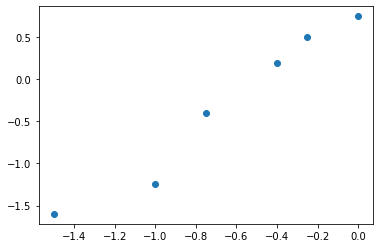

In [ ]:
# training, test points and visualization
x_train = np.array([-1.5, -1.0, -0.75, -0.4, -0.25, 0.0]).reshape(-1, 1)
y_train = np.array([-1.6, -1.25, -0.4, 0.2, 0.5, 0.75]).reshape(-1, 1)
x_test = np.linspace(-1.7, 0.4, 50).reshape(-1, 1)
x_test2 = np.linspace(-5, 5, 50).reshape(-1, 1)

plt.scatter(x_train, y_train)
plt.show()

In [ ]:
# squared exponential covariance function
# with hyperparameters sigma_f and l
def se(x, y, sigma_f, l):
  fraction = -1/(2 * l**2) * (x - y)**2
  exponential = np.exp(fraction)
  return sigma_f ** 2 * exponential

In [ ]:
# looking at GP prior
def compute_and_plot_gp_prior(l, sigma_f):
  se_kernel_function = lambda x, y: se(x, y, sigma_f, l)
  construct_se_kernel_matrix = lambda x, y : construct_kernel(x, y, se_kernel_function)

  x_vals = np.linspace(-2, 1, num=50).reshape(-1, 1)

  prior_kernel = construct_se_kernel_matrix(x_vals, x_vals)

  # sample
  prior_samples = []
  # sample 100 times
  for i in range(100):
    prior_samples.append(np.random.multivariate_normal(np.zeros(len(x_vals)), prior_kernel))

  # visualize results
  fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

  # Plot the prior samples
  for sample in prior_samples:
    ax.plot(x_vals, sample, color='blue', alpha=0.2)

  ax.set_title('Visualization of RBF Kernel Evaluated from [-5, 5] with l: {}, sigma_f: {}'.format(l, sigma_f))

  plt.show() # display the figure

In [ ]:
def compute_and_plot_kernel_matrix(l, sigma_f):
  se_kernel_function = lambda x, y: se(x, y, sigma_f, l)
  construct_se_kernel_matrix = lambda x, y : construct_kernel(x, y, se_kernel_function)

  x_vals = np.linspace(-5, 5, num=50).reshape(-1, 1)

  prior_kernel = construct_se_kernel_matrix(x_vals, x_vals)

  # SE kernel
  ax = sns.heatmap(prior_kernel, linewidth=0.5)
  plt.show()

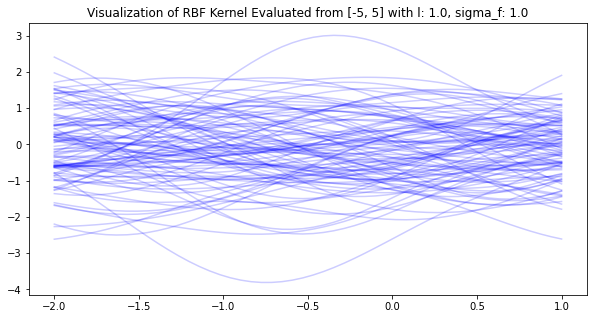

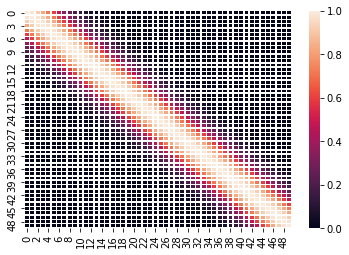

In [ ]:
compute_and_plot_gp_prior(1.0, 1.0)
compute_and_plot_kernel_matrix(1.0, 1.0)

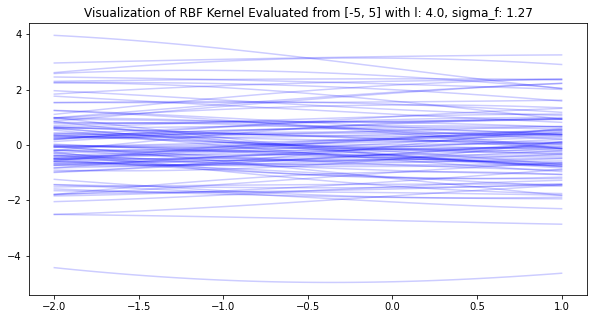

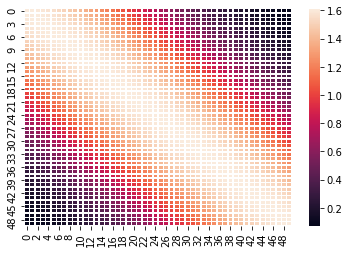

In [ ]:
compute_and_plot_gp_prior(4.0, 1.27)
compute_and_plot_kernel_matrix(4.0, 1.27)

In [ ]:
def predict_with_se_kernel(l, sigma_f, x_train, y_train, x_test):
  se_kernel_function = lambda x, y: se(x, y, sigma_f, l)
  construct_se_kernel_matrix = lambda x, y : construct_kernel(x, y, se_kernel_function)

  # compute the mean and covariance values
  se_mean, se_variance = compute_mean_and_covariance(construct_se_kernel_matrix, x_train, x_test, y_train)

  # sampling from our distribution and obtaining function values on test inputs
  num_samples = 1000
  y_preds = []

  for i in range(num_samples):
    y_preds.append(np.random.multivariate_normal(se_mean.flatten(), se_variance))

  y_preds = np.array(y_preds)

  # computing 95th percentile predictive intervals
  y_pred_ub = np.percentile(y_preds, 97.5, axis = 0)
  y_pred_mean = np.percentile(y_preds, 50.0, axis = 0)
  y_pred_lb = np.percentile(y_preds, 2.5, axis = 0)

  return y_pred_ub, y_pred_mean, y_pred_lb

def plot_gp_preds_and_likelihood(l, sigma_f, x_train, y_train, x_test):

  y_pred_ub, y_pred_mean, y_pred_lb = predict_with_se_kernel(l, sigma_f, x_train, y_train, x_test)

  # visualize results
  fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
  ax.scatter(x_train, y_train, label='training data') # scatter plot the training data
  # plot uncertainty between upper and lower bounds
  ax.fill_between(x_test.flatten(), y_pred_ub, y_pred_lb, color='blue', alpha=0.2)

  # Plot the predictive samples
  ax.plot(x_test.flatten(), y_pred_mean, '--', color='blue', label='predictive mean')

  # compute log likelihood
  llkhd = log_likelihood([l, sigma_f], 0)

  ax.set_title('GP model with Length Scale: {}, Sigma f: {}, Log Likelihood: {}'.format(l, sigma_f, llkhd))
  ax.legend(loc='best') # display legend
  plt.show() # display the figure

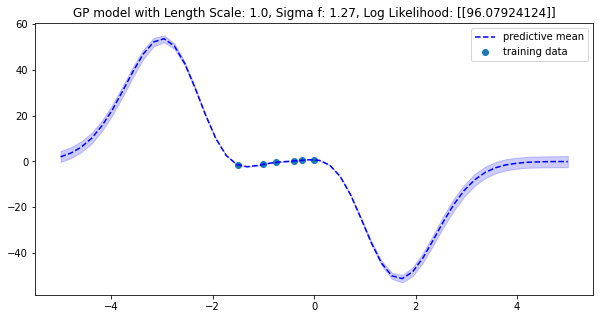

In [ ]:
# why did they get a better optima?
# what factors in the prior or model selection contribute to the narrow predictive uncertainty
# if this is indeed the optima, is this the function you want? 
# correct in a sense you get the highest log likelihood
# branching point: 1) I chose wrong, choice in SE kernel, prior was wrong, choosing a different model class
# 2) if search allows you to fit a really really specific model class (overfitting) is that what we want?
# additional question, why is there a huge dip? do during pair work
plot_gp_preds_and_likelihood(1.0, 1.27, x_train, y_train, x_test2)

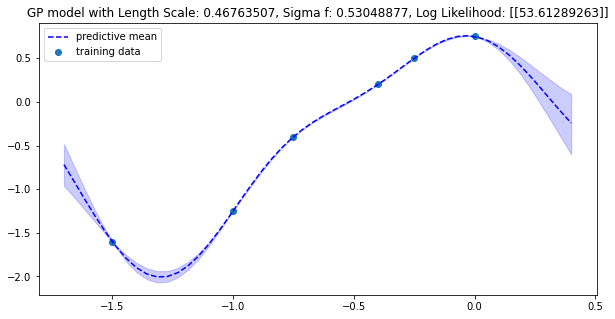

In [ ]:
plot_gp_preds_and_likelihood(0.46763507, 0.53048877, x_train, y_train, x_test)

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: covariance is not positive-semidefinite.
  return f_raw(*args, **kwargs)


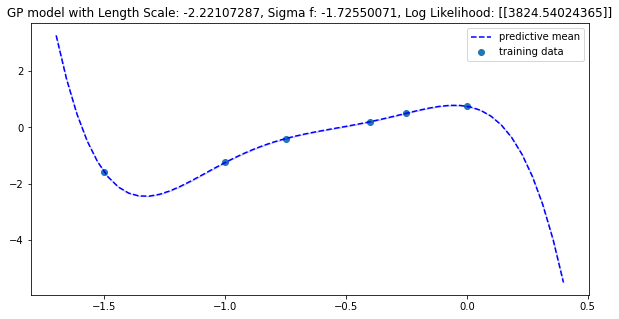

In [ ]:
plot_gp_preds_and_likelihood(-2.22107287, -1.72550071, x_train, y_train, x_test)

Anna Concern: Question for Wei Wei, how come my predictive intervals are so narrow? they're not 0 exactly but very very narrow.

Anna Answer: Changing the length scale hyperparameter causes the uncertainty intervals to change. If I increase the length scale from 1 to 4, the uncertainty intervals look a lot better.

**Step 3:** Hyperparameter Tuning

###**Method 1: Minimizing Objective Score with Grid and Random Search**

---
Resources:
* [Bayeisan Hyperparameter Optimization Article](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)

* [Random Search Paper](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

We want to find $\theta^*$ such that $$
\theta^* = \underset{\theta \in \Theta}{\mathrm{argmin}}\ f(\theta)
$$

In this case, $f(x)$ represents an objective score to minimize such as RMSE or error rate evaluated on the validation set. **We want to find the model hyperparameters that yield the best score on the validation set metric.**

**Pro:** 
* Grid search and random search are slightly better than manual tuning as it's an algorithmic approach to choosing hyperparameters 

**Con:** 
* Grid and random search are completely uninformed by past evaluations and spend a significant time evaluating bad hyperparameters.
* Therefore these methods are relatively inefficient.

Idea: Quadrature? 

In [ ]:
# mean squared error
def mean_squared_error(y_pred, y_true):
  n = len(y_true)
  return 1/n * np.sum((y_pred - y_true)**2)

In [ ]:
# Naive Grid Search
def execute_naive_grid_search(grid_length, x_vals, y_vals):
  # build The Grid
  ls = np.linspace(0.1, 4, num=grid_length)
  sigmas = np.linspace(0.1, 4, num=grid_length)
  scores = np.zeros((grid_length, grid_length))

  # iterate over values of l
  for i in range(grid_length):
    # iterate over values of sigma_f
    for j in range(grid_length):
      l, sigma_f = ls[i], sigmas[j]
      # prediction
      _, y_pred_mean, _ = predict_with_se_kernel(l, sigma_f, x_train, y_train, x_vals)
      # compare and evaluate score
      score = mean_squared_error(y_pred_mean, y_vals)
      scores[i][j] = score

  ind = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
  best_l, best_sig, best_score = ls[ind[0]], ls[ind[1]], scores[ind[0]][ind[1]]
  return best_l, best_sig, best_score

In [ ]:
x_vals = np.array([-0.5, -2.0, 0.1]).reshape(-1, 1)
y_vals = np.array([-0.1, 0.1, 0.8]).reshape(-1, 1)

best_l, best_sig, best_score = execute_naive_grid_search(20, x_vals, y_vals)

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: covariance is not positive-semidefinite.
  return f_raw(*args, **kwargs)


In [ ]:
print(best_l)
print(best_sig)
print(best_score)

0.1
3.1789473684210527
0.5732095027856499


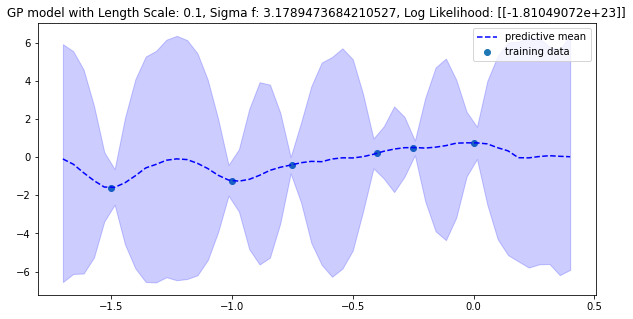

In [ ]:
plot_gp_preds_and_likelihood(best_l, best_sig, x_train, y_train, x_test)

###**Method 2: Maximum Likelihood**


---


Let $\theta = \{ l, \sigma_f, \sigma_n\}$. Our **maximum a posteriori** estimate of $\theta$ occurs when $p(\theta, x, y)$ is at its greatest.

**Bayes' Theorem** says: $p(\theta | x, y) = p(y| x, \theta)p(\theta)$. With the prior $p(\theta)$ not well known, we want to maximize the likelihood $p(y| x, \theta)$. 

Let's assume for simplicity that we are only looking at the function $f$ without the noise term which creates $y$. 

Since Log-Likelihood: $\log p(f|x, \theta) = -\frac{1}{2}f^TK^{-1}f - \frac{1}{2} \log \det K - \frac{n}{2} \log 2\pi$

We obtained this result because $f \sim \mathcal{N}(0, K)$ by assumption of the Gaussian Process. The equation falls out trivially from the pdf of a Multivariate Gaussian. 

We can then run our favourite multivariate optimization algorithm (i.e. **conjugate gradients**, **Nelder-Mead Simplex**, etc.)

In [ ]:
# Proxy likelihood function
# parameters are a vector [l, sigma_f]
def l_objective(params, t):
  return log_likelihood(params, t)

# Print function for likelihood objective optimization
def likelihood_callback(params, t, gradient):
    if  t % 100 == 0:
        print("Iteration {} lower bound {}; gradient mag: {}".format(t, l_objective(params, t), np.sum(gradient)))

# computing the gradient of l_objective
gradient = grad(l_objective)
    
#initialize variational parameters
init_var_params = np.random.normal(0, 1, size = (2,))
step_size = 0.01
max_iterations = 2500

#perform gradient descent using adam (a type of gradient-based optimizer)
W_opt = adam(gradient, init_var_params.flatten(), step_size=step_size, num_iters=max_iterations, callback=likelihood_callback)
 

In [ ]:
print(W_opt)

[ 0.39571699 14.91560108]


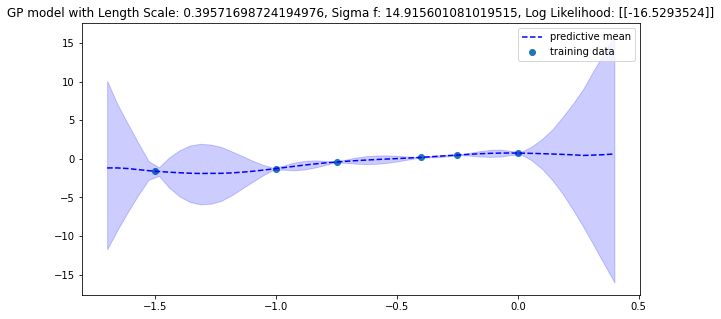

In [ ]:
plot_gp_preds_and_likelihood(W_opt[0], W_opt[1], x_train, y_train, x_test)

In [ ]:
# ANNA TODO: try random restarts with init pos with paper hyperparameter optimization
def execute_grad_with_random_restarts(num_trials, max_iterations):
  # computing the gradient of l_objective
  gradient = grad(l_objective)
  step_size = 0.01
  Ws = []
  restarts = []

  for i in range(num_trials):
    init_var_params = np.random.normal(0, 2, size = (2,))
    W_opt = adam(gradient, init_var_params.flatten(), step_size=step_size, num_iters=max_iterations, callback=likelihood_callback)
    Ws.append(W_opt)
    restarts.append(init_var_params)

  return Ws, restarts

In [ ]:
def plot_random_restarts(Ws, restarts, x_test):
  n = len(Ws)
  # visualize results
  fig, ax = plt.subplots(n // 4, 4, figsize=(30, 10)) # make a figure with one row and one column of size 10x5

  for i in range(n):
    # unpack params
    l, sigma_f = unpack_params(Ws[i])

    # we cannot handle nan values
    if (np.isnan(Ws[i]).any()):
      continue

    y_pred_ub, y_pred_mean, y_pred_lb = predict_with_se_kernel(l, sigma_f, x_train, y_train, x_test)

    row = i // 4
    col = i % 4
    ax[row][col].scatter(x_train, y_train, label='training data') # scatter plot the training data
    # plot uncertainty between upper and lower bounds
    ax[row][col].fill_between(x_test.flatten(), y_pred_ub, y_pred_lb, color='blue', alpha=0.2)

    # Plot the predictive samples
    ax[row][col].plot(x_test.flatten(), y_pred_mean, '--', color='blue', label='predictive mean')

    # compute log likelihood
    llkhd = log_likelihood([l, sigma_f], 0)

    # plot parameter values
    ax[row][col].plot([], [], '', label='Init Pos: {}'.format(restarts[i]))
    ax[row][col].plot([], [], '', label='l: {}'.format(l))
    ax[row][col].plot([], [], '', label='Sigma_f: {}'.format(sigma_f))
    ax[row][col].plot([], [], '', label='LLkhd: {}'.format(llkhd))

    # ax[row][col].set_title('Init Pos: {}, l: {}, Sig_f: {}, LLkhd: {}'.format(restarts[i], l, sigma_f, llkhd))
    ax[row][col].legend(loc='best') # display legend
  plt.show() # display the figure

In [ ]:
#perform gradient descent with random restarts
Ws, restarts = execute_grad_with_random_restarts(num_trials=8, max_iterations=2500)

Iteration 0 lower bound [[1082.72279932]]; gradient mag: -15264.71424361731
Iteration 100 lower bound [[79.64182696]]; gradient mag: -358.0260891231873
Iteration 200 lower bound [[51.44902675]]; gradient mag: -188.06329921406711
Iteration 300 lower bound [[38.6292407]]; gradient mag: -124.64013985118021
Iteration 400 lower bound [[31.06125484]]; gradient mag: -92.08362616242277
Iteration 500 lower bound [[25.96545888]]; gradient mag: -72.42684158670328
Iteration 600 lower bound [[22.24895931]]; gradient mag: -59.33331093523768
Iteration 700 lower bound [[19.3886124]]; gradient mag: -50.01582983749528
Iteration 800 lower bound [[17.10022121]]; gradient mag: -43.0625347519784
Iteration 900 lower bound [[15.21505562]]; gradient mag: -37.683986010836
Iteration 1000 lower bound [[13.62610414]]; gradient mag: -33.405207876722436
Iteration 1100 lower bound [[12.26194209]]; gradient mag: -29.923770255509677
Iteration 1200 lower bound [[11.07291512]]; gradient mag: -27.038213045939962
Iteration

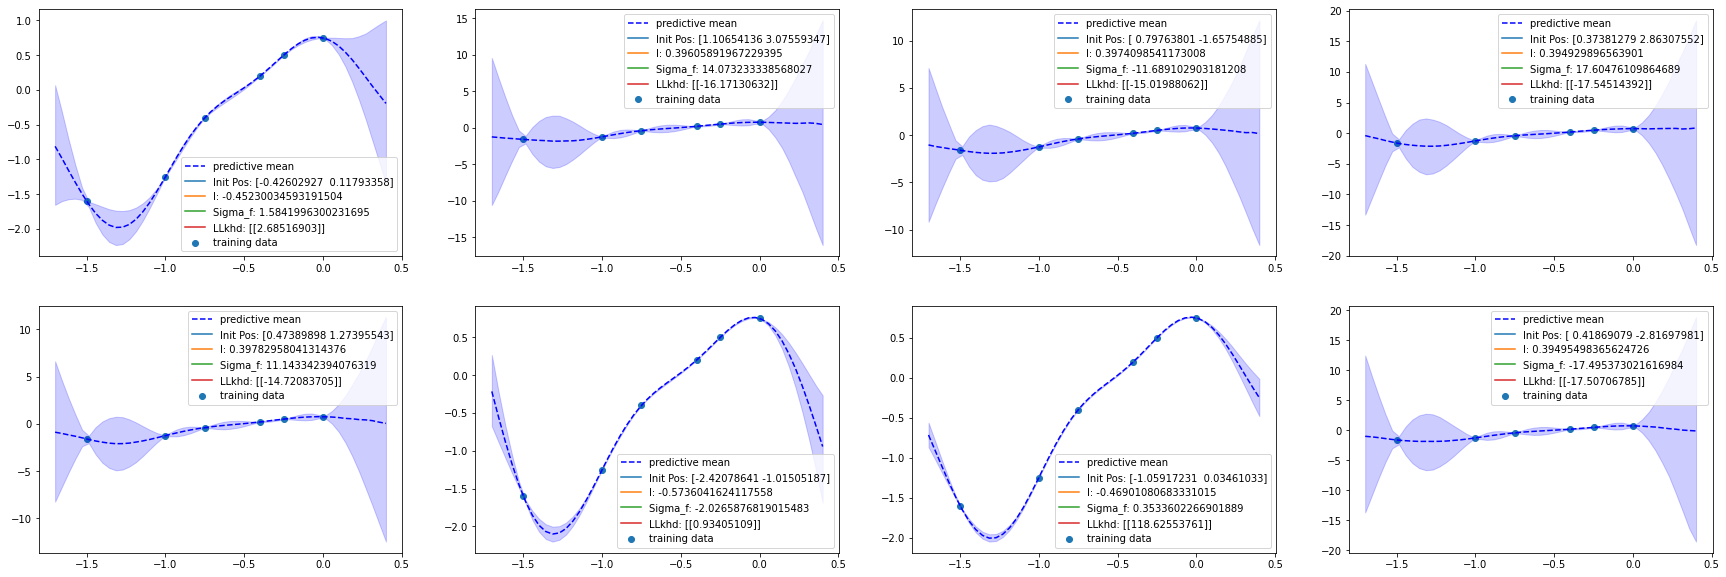

In [ ]:
plot_random_restarts(Ws, restarts, x_test)

In [ ]:
# ANNA TODO: make a contour plot of likelihood w.r.t. sigma_f and l to see if it gets stuck in local optima

###**Method 3: Bayesian Optimization**
---
References:

* [Scalable Bayesian Optimization Using Deep Neural Networks](https://arxiv.org/pdf/1502.05700.pdf)

* [Bayesian Optimization with GPs Article](https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0)

* [Bayeisan Hyperparameter Optimization Article](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)


### **Method 4: Sampling From the Posterior Via Hamiltonian Monte Carlo**

## **Parameterizing the Covariance Function**

---
### **Covariance Function**
The following covariance function works well:

$$
C(x, x') = v_0\exp \left\{ -\frac{1}{2}\sum_{l = 1}^d w_l(x_l - x_l')^2 \right\} + a_0 + a1\sum_{l = 1}^d x_lx_l' + v_1\delta(x, x')
$$

Question: what exactly is the noise term and how is it computed?!

In [ ]:
# covariance/kernel function used in the paper
# theta is an array of hyperparameter values of the form (v0, v1, w1,.., wd, a0, a1)
# for 1-dimensional inputs
def C(x, y, theta):
  v0 = theta[0]
  v1 = theta[1]
  ws = theta[2]
  a0 = theta[-1]
  a1 = theta[-2]
  exponent_term = v0 * np.exp(-0.5 * ws * (x - y)**2)
  linear_term = a0 + a1 * x * y
  # noise_term = v1 * np.random.normal(0, 1)
  noise_term = v1
  result = exponent_term + linear_term + noise_term
  return result[0]

Let $\theta = log(v_0, v_1, w_1,...,w_d, a_0, a_1$ play the role of hyperparameters. We define the hyperparameters to be the log of the variables since they are positive scale-parameters.

The covariance term is made up of 3 parts:

1. Exponent Term 
* captures that nearby inputs will have highly correlated outputs
* the $w_l$ weights allow a different distance measure for each input dimension. For irrelevant inputs, the weights will be small and the model will ignore the input. (Close to the Automatic Relevance Determination (ARD) idea of **MacKay** and **Neal**.
* $v_0$ variable gives the overall scale of the local correlations

2. Linear Term
* a_0, a_1 control the scale and the bias and linear contributions to the covariance

3. Noise Term
* accounts for noise on the data and $v_1$ is the variance of the noise

### **Log-Likelihood of Training Data**
The training data is $(X, Y)$ where $Y \in \mathbb{R}^n$ and $X \in \mathbb{R}^{n x d}.$

Recall: $y = f(x) + \epsilon_i$ where $f(x) \sim \mathcal{N}(0, K(x, x))$ (since we're viewing f(x) in the function space view of a GP) and $\epsilon_i \sim \mathcal{N}(0, v_1I_n)
=> y \sim \mathcal{N}(f(x), v_1I_n).$

Given the covariance matrix $K$, the log likelihood of the training data $\textbf{f}$ is given by:

$$
l_f = p(\textbf{f} | x, \theta) = -\frac{1}{2} \log \det K - \frac{1}{2}\textbf{f}^TK^{-1}\textbf{f} - \frac{n}{2} \log 2\pi
$$

Note: the kernel $K$ is n by n and each entry in this matrix is given by the first 3 terms in the covariance expression $C(x,x')$  (leave out the last $v_1$ term.)

The log likelihood of the prediction $y$ is:
$$
l_y = p(y | \textbf{f}) = -\frac{n}{2} \log(v_1) - \frac{1}{2v_1}(Y-\textbf{f})^T(Y-\textbf{f}) - \frac{n}{2} \log 2\pi
$$


## **Tuning Hyperparameters for a Gaussian Process**

### **Method 1: Maximum Likelihood**
In the maximum likelihood framework, we adjust the hyperparameters to maximize the likelihood of the training data. We initialize the hyperparameters to random values (in a reasonable range) and then use an iterative method (e.g. conjugate gradient) to search for optimal values of the hyperparameters. 

Since there are only a small number of hyperparameters $(d + 4)$, a relatively small number of iterations are sufficient for convergence.

However, this approach is susceptible to local minima so we need to try a number of random starting positions in the hyperparameter space. 

### **Method 2: Sampling From the Posterior Via Hamiltonian Monte Carlo**

## **Experiments**

### **Data Generation**

We generate toy data from a cubic function $y = x^3 + \mathcal{N}(0, 3^2)$ with constant variance.

In [ ]:
# generate toy data from a cubic function 
#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

noise_var = 3**2
f_1 = lambda x: x**3 + random.normal(0, noise_var**0.5, size=x.shape)

# number of data points * 2
N = 50
x_train = np.hstack((np.linspace(-4, -2, N), np.linspace(2, 4, N))).reshape((-1, 1))
x_test = np.linspace(-4, 4, 200).reshape(-1,1)
y_train = f_1(x_train).reshape(-1, 1)

plt.scatter(x_train, y_train, color='#94d2eb')
plt.title('training data')
plt.show()

In [ ]:
# # generate toy data from a cubic function 
# #set random state to make the experiments replicable
# rand_state = 0
# random = np.random.RandomState(rand_state)

# noise_var = 3**2
# f_1 = lambda x: x**3 + random.normal(0, noise_var**0.5, size=x.shape)

# # number of data points * 2
# N = 200
# x_train = np.random.uniform(-1.932, -0.453, size=N).reshape(-1, 1)
# y_train = np.random.uniform(0.453, 1.932, size=N).reshape(-1, 1)
# x_test = np.random.uniform(0.534, 3.142, size=N).reshape(-1, 1)

# plt.scatter(x_train, y_train, color='#94d2eb')
# plt.title('training data')
# plt.show()

### **Maximum Likelihood Method**

ANNA TODO: CALCULATE THE GRADIENT WITH RESPECT TO EACH HYPERPARAMETER!

$$
l = -\frac{1}{2} \log \det K - \frac{1}{2}\textbf{f}^TK^{-1}\textbf{f} - \frac{n}{2} \log 2\pi
$$

$$
=> \frac{dl}{dv_0} = -\frac{1}{2} * \frac{1}{\det K} * \frac{d}{v_0} \det K * \frac{d}{dv_0}K
$$

In [ ]:
# log likelihood function
def log_likelihood(K, f):
  n = len(f)
  # add a bit of noise for numerical stability 
  K = 10**(-3) * np.identity(len(K)) + np.copy(K)
  first = -0.5 * np.log(np.linalg.det(K))
  second = 0.5 * f.T @ np.linalg.inv(K) @ f
  third = n / 2 * np.log(2 * np.pi)
  result = first - second - third
  return result[0][0]

# TO DO Implement conjugate gradient ascent to maximize likelihood
def likelihood_gradient():
  return null

# conjugate gradient ascent

In [ ]:
# randomly initialize theta
theta = np.array([1, 1, 2, 3, 3])
kernel_function = lambda x, y: C(x, y, theta)
# kernel matrix constructed with training data
kernel_matrix = construct_kernel(x_train, x_train, kernel_function)

In [ ]:
# log likelihood function unit test
print(log_likelihood(kernel_matrix, y_train))

### **Posterior Sampling Using Hamiltonian Monte Carlo**

ANNA TODO: Why do we need to run HMC? Aren't we assuming the weights are Gaussian and the likelihood of the data under the hyperparameters are also Gaussian? If not, what's the distribution of the likelihood? What's the distribution of the prior?

In [ ]:
N = 100
# X = np.linspace(-4, 4, N)[:, None]

# HMC Implementation
with pm.Model() as hmc_model:
  # define priors 
  mu = 0
  sigma = 1
  # hyperparameter of the covariance
  theta = pm.Normal('theta', mu=mu, sigma=sigma)
  
  # kernel is an exponential kernel
  cov = pm.gp.cov.Exponential(1, ls_inv=theta)

  gp = pm.gp.Latent(cov_func=cov)

  # Place a GP prior over the function f.
  f = gp.prior("f", X=x_train)

  # defining labels f
  f_cond = gp.conditional("fcond", Xnew=x_test)


In [ ]:
#draw graphical model for the thing we just defined  
model_to_graphviz(hmc_model)

In [ ]:
# Sample Thetas
with hmc_model:
  # specifying specific sampler
  steps = pm.HamiltonianMC()
  # use HMC sampler to sample from posterior
  trace = pm.sample(100, tune=100, step = steps)

In [ ]:
# Burn and Thin
#defined burn-in
burn_in = .1
#define thinning
thin = 2

# Plot Samples

# Obtain Functions for Each Theta

# Calculate Error

PYMC3 Docs:

- Kronecker Strcutured Covariances: https://docs.pymc.io/notebooks/GP-Kron.html

- GP Marginal Likelihood: https://docs.pymc.io/notebooks/GP-Marginal.html

- GP Implementations: https://docs.pymc.io/api/gp/implementations.html

- GP Means and Covariances: https://docs.pymc.io/notebooks/GP-MeansAndCovs.html

- General GPs: https://docs.pymc.io/notebooks/gaussian_process.html